In [1]:
nb_name = 'read_ERA_calculate_anomalies_loop.ipynb'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

In [4]:
import pathlib

In [5]:
HOME = pathlib.Path.home()

In [6]:
HOME

PosixPath('/home/nicolasf')

In [7]:
var_dict_replace = {}
var_dict_replace['T2M'] = None 
var_dict_replace['PRECIP'] = {'tp':'precip'} 
var_dict_replace['SST'] = None

In [8]:
dim_dict_replace = {}
dim_dict_replace['latitude'] = 'lat'
dim_dict_replace['longitude'] = 'lon'

In [9]:
var_name = 'SST'

In [10]:
dpath = HOME / 'drives' / 'auck_projects' / 'END19101' / 'Working' / 'data' / 'REANALYSIS' / 'downloads' / 'ERA5' / var_name

In [11]:
lfiles = list(dpath.glob("*.nc"))

In [12]:
lfiles.sort()

In [13]:
lfiles[:10]

[PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_06.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_07.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_08.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_09.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_10.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_11.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_12.nc')]

In [14]:
lfiles[-10:]

[PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_06.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_07.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_08.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_09.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_10.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_11.nc'),
 PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/SST/ERA5_monthly_SST_2016_12.nc')]

In [15]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested')

In [16]:
dset.nbytes / 1e9

1.893762052

### replace variable names if needed

In [17]:
if var_dict_replace[var_name] is not None: 
    dset = dset.rename_vars(var_dict_replace[var_name])

In [18]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 456)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-17 11:32:43 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [19]:
dset = dset.rename(dim_dict_replace) 

In [20]:
dset

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 456)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-17 11:32:43 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

### make sure that there are no values below zero 

In [21]:
if var_name == 'PRECIP': 
    dset[var_name.lower()] = dset[var_name.lower()].clip(min=0.)

### calculate the monthly climatology 

In [22]:
clim_m = dset.sel(time=slice('1993','2016'))

In [23]:
clim_m = clim_m.groupby(clim_m.time.dt.month).mean()

### calculate the monthly anomalies 

In [24]:
anoms_m = dset.groupby(dset.time.dt.month) - clim_m

### calculate the seasonal averages from the monthly dataset 

In [25]:
dset_rm = dset.rolling(time=3, min_periods=3).mean()

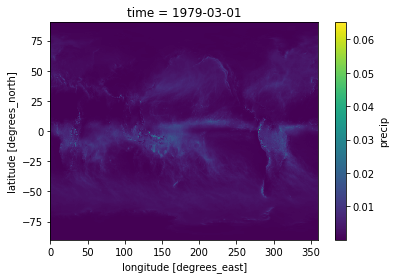

In [26]:
dset_rm.isel(time=2)[var_name.lower()].plot()

### removes the first 2 data points

In [27]:
dset_rm = dset_rm.isel(time=slice(2,None))

### calculate the seasonal climatology 

In [28]:
clim_s = dset_rm.sel(time=slice('1993','2016'))

In [29]:
clim_s = clim_s.groupby(clim_s.time.dt.month).mean()

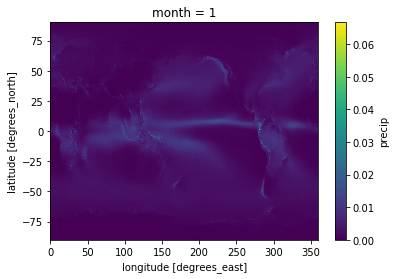

In [30]:
clim_s.sel(month=1)[var_name.lower()].plot(vmin=0)

### calculate the seasonal anomalies 

In [31]:
anoms_s = dset_rm.groupby(dset_rm.time.dt.month) - clim_s

In [32]:
anoms_s

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 454)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 1979-03-01 1979-04-01 ... 2016-12-01
    month    (time) int64 3 4 5 6 7 8 9 10 11 12 1 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

### saves the climatologies as one file (each)

In [33]:
dpath

PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/downloads/ERA5/PRECIP')

In [34]:
dpath_clim = pathlib.Path(str(dpath).replace('downloads','processed')) / 'CLIMATOLOGY'

In [35]:
dpath_anoms = pathlib.Path(str(dpath).replace('downloads','processed'))

In [36]:
dpath_clim

PosixPath('/home/nicolasf/drives/auck_projects/END19101/Working/data/REANALYSIS/processed/ERA5/PRECIP/CLIMATOLOGY')

In [37]:
if not dpath_clim.exists(): 
    dpath_clim.mkdir(parents=True)

In [38]:
var_name

'PRECIP'

### monthly climatology 

In [39]:
clim_m.to_netcdf(dpath_clim / f'CLIMATOLOGY_MONTHLY_ERA5_{var_name}_1993_2016.nc')

### seasonal climatology 

In [40]:
clim_s.to_netcdf(dpath_clim / f'CLIMATOLOGY_SEASONAL_ERA5_{var_name}_1993_2016.nc')

### now saves the anomalies (one file per month and season) in the processed PATH 

In [41]:
for date in pd.to_datetime(anoms_m.time.data): 
    print(f"saving the monthly anomalies for date {date:%Y_%m}") 
    sub_m = anoms_m.sel(time = date)
    sub_m.to_netcdf(dpath_anoms / f"ERA5_monthly_anomalies_{var_name}_{date:%Y_%m}.nc")
    sub_m.close() 

saving the monthly anomalies for date 1979_01
saving the monthly anomalies for date 1979_02
saving the monthly anomalies for date 1979_03
saving the monthly anomalies for date 1979_04
saving the monthly anomalies for date 1979_05
saving the monthly anomalies for date 1979_06
saving the monthly anomalies for date 1979_07
saving the monthly anomalies for date 1979_08
saving the monthly anomalies for date 1979_09
saving the monthly anomalies for date 1979_10
saving the monthly anomalies for date 1979_11
saving the monthly anomalies for date 1979_12
saving the monthly anomalies for date 1980_01
saving the monthly anomalies for date 1980_02
saving the monthly anomalies for date 1980_03
saving the monthly anomalies for date 1980_04
saving the monthly anomalies for date 1980_05
saving the monthly anomalies for date 1980_06
saving the monthly anomalies for date 1980_07
saving the monthly anomalies for date 1980_08
saving the monthly anomalies for date 1980_09
saving the monthly anomalies for d

In [42]:
for date in pd.to_datetime(anoms_s.time.data): 
    print(f"saving the seasonal anomalies for date {date:%Y_%m}") 
    sub_s = anoms_s.sel(time = date)
    sub_s.to_netcdf(dpath_anoms / f"ERA5_seasonal_anomalies_{var_name}_{date:%Y_%m}.nc")
    sub_s.close() 

saving the seasonal anomalies for date 1979_03
saving the seasonal anomalies for date 1979_04
saving the seasonal anomalies for date 1979_05
saving the seasonal anomalies for date 1979_06
saving the seasonal anomalies for date 1979_07
saving the seasonal anomalies for date 1979_08
saving the seasonal anomalies for date 1979_09
saving the seasonal anomalies for date 1979_10
saving the seasonal anomalies for date 1979_11
saving the seasonal anomalies for date 1979_12
saving the seasonal anomalies for date 1980_01
saving the seasonal anomalies for date 1980_02
saving the seasonal anomalies for date 1980_03
saving the seasonal anomalies for date 1980_04
saving the seasonal anomalies for date 1980_05
saving the seasonal anomalies for date 1980_06
saving the seasonal anomalies for date 1980_07
saving the seasonal anomalies for date 1980_08
saving the seasonal anomalies for date 1980_09
saving the seasonal anomalies for date 1980_10
saving the seasonal anomalies for date 1980_11
saving the se